In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Training Data.csv')
train_data = df
y = train_data['risk_flag']
train_data.drop(['Id', 'risk_flag'], axis=1, inplace=True)
train_data.head()

,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years
0,1303835,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13
1,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13
2,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10
3,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12
4,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14


In [205]:
test_data = pd.read_csv('Test Data.csv')
test_data.drop(["id"], axis=1, inplace=True)
test_data.head()

,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years
0,7393090,59,19,single,rented,no,Geologist,Malda,West Bengal,4,13
1,1215004,25,5,single,rented,no,Firefighter,Jalna,Maharashtra,5,10
2,8901342,50,12,single,rented,no,Lawyer,Thane,Maharashtra,9,14
3,1944421,49,9,married,rented,yes,Analyst,Latur,Maharashtra,3,12
4,13429,25,18,single,rented,yes,Comedian,Berhampore,West Bengal,13,11


In [206]:
train_data.shape

(252000, 11)

In [207]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   income               252000 non-null  int64 
 1   age                  252000 non-null  int64 
 2   experience           252000 non-null  int64 
 3   married              252000 non-null  object
 4   house_ownership      252000 non-null  object
 5   car_ownership        252000 non-null  object
 6   profession           252000 non-null  object
 7   city                 252000 non-null  object
 8   state                252000 non-null  object
 9   current_job_years    252000 non-null  int64 
 10  current_house_years  252000 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 21.1+ MB


In [208]:
y.value_counts()

0    221004
1     30996
Name: risk_flag, dtype: int64

In [209]:
round(100 * y.value_counts()/len(train_data), 2)

0    87.7
1    12.3
Name: risk_flag, dtype: float64

In [210]:
train_data.nunique()

income                 41917
age                       59
experience                21
married                    2
house_ownership            3
car_ownership              2
profession                51
city                     317
state                     29
current_job_years         15
current_house_years        5
dtype: int64

<AxesSubplot:>

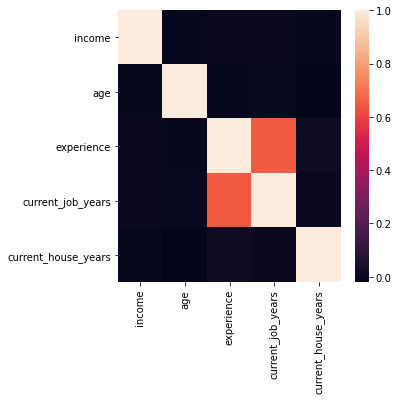

In [211]:
plt.figure(figsize=(5, 5))
sns.heatmap(df.corr())

In [212]:
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as imb_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer, LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.neighbors import LocalOutlierFactor
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import category_encoders as ce

# class TypeSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, dtype):
#         self.dtype = dtype
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X):
#         assert isinstance(X, pd.DataFrame)
#         return X.select_dtypes(include=[self.dtype])



class OutlierExtractor(TransformerMixin):
    def __init__(self, **kwargs):
        """
        Create a transformer to remove outliers. A threshold is set for selection
        criteria, and further arguments are passed to the LocalOutlierFactor class

        Keyword Args:
            neg_conf_val (float): The threshold for excluding samples with a lower
               negative outlier factor.

        Returns:
            object: to be used as a transformer method as part of Pipeline()
        """

        self.threshold = kwargs.pop('neg_conf_val', -10.0)

        self.kwargs = kwargs

    def transform(self, X, y):
        """
        Uses LocalOutlierFactor class to subselect data based on some threshold

        Returns:
            ndarray: subsampled data

        Notes:
            X should be of shape (n_samples, n_features)
        """
        X = np.asarray(X)
        y = np.asarray(y)
        lcf = LocalOutlierFactor(**self.kwargs)
        lcf.fit(X)
        return (X[lcf.negative_outlier_factor_ > self.threshold, :],
                y[lcf.negative_outlier_factor_ > self.threshold])

    def fit(self, *args, **kwargs):
        return self

In [213]:
train_data["profession"] =pd.factorize(train_data.profession, sort=True)[0]
train_data["city"] =pd.factorize(train_data.city, sort=True)[0]
train_data["state"]=pd.factorize(train_data.state, sort=True)[0]
train_data["married"]=pd.factorize(train_data.married, sort=True)[0]
train_data["house_ownership"]=pd.factorize(train_data.house_ownership, sort=True)[0]
train_data["car_ownership"]=pd.factorize(train_data.car_ownership, sort=True)[0]

test_data["profession"] = pd.factorize(test_data.profession, sort=True)[0]
test_data["city"] =pd.factorize(test_data.city, sort=True)[0]
test_data["state"]=pd.factorize(test_data.state, sort=True)[0]
test_data["married"]=pd.factorize(test_data.married, sort=True)[0]
test_data["house_ownership"]=pd.factorize(test_data.house_ownership, sort=True)[0]
test_data["car_ownership"]=pd.factorize(test_data.car_ownership, sort=True)[0]


In [214]:
# adding in capital and cities of economic imp columns
def city_features(row):
    row['city']=row['city'].split('[')[0]
    row['state']=row['state'].lower()
    
    of_economic_imp=['Chennai','Kalyan-Dombivli','Hyderabad','Malegaon','Mumbai',
                     'Delhi_city','Bangalore','New_Delhi','Mira-Bhayandar','Navi_Mumbai'
                    'Vasai-Virar','Kolkata','Mangalore','Jabalpur','Thane','Pune',
                    'Ambarnath','Panvel','Secunderabad','Noida','Visakhapatnam',
                    'Jamshedpur','Pimpri-Chinchwad','Ahmedabad','Surat','Jaipur',
                    'Nagpur','Indore','Patna']
    
    capital_cities=['Bhopal','Pondicherry','Chennai','Shimla','Hyderabad','Aizawl',
                    'Mumbai','Kochi','Srinagar','Patna','Delhi_city',
                    'Chandigarh_city','Jammu','Lucknow','Bangalore','New_Delhi',
                   'Imphal','Kolkata','Gangtok','Dehradun','Aizawl','Raipur',
                   'Ranchi','Thiruvananthapuram','Gandhinagar','Shillong','Kohima',
                   'Itanagar','Dispur','Panaji','Jaipur','Agartala']
    
    
    row['capital']=int(str(row['city']) in capital_cities)
    row['econ_imp']=int(str(row['city']) in of_economic_imp)
    
    return row

In [215]:
def location_data(train,test,y):

    train=train.apply(lambda x: city_features(x),axis=1)
    test=test.apply(lambda x: city_features(x),axis=1)

    train['location'] = train.city +','+ train.state
    test['location'] = test.city + ','+ train.state
    
    train.drop(['state','city'],axis=1,inplace=True)
    test.drop(['state','city'],axis=1,inplace=True)
    
    enc=ce.cat_boost.CatBoostEncoder(cols=['location'])
    enc.fit(train,y)
    
    train = enc.transform(train)
    test = enc.transform(test)
   
    return train,test

In [216]:
# train_data,test_data = location_data(train_data,test_data,y)

In [217]:
# enc2=ce.cat_boost.CatBoostEncoder(cols=['profession'])
# enc2.fit(train_data,y)
    
# train_data = enc2.transform(train_data)
# test_data = enc2.transform(test_data)

In [218]:
train_data.head()

,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years
0,1303835,23,3,1,2,0,33,251,13,3,13
1,7574516,40,10,1,2,0,43,227,14,9,13
2,3991815,66,4,0,2,0,47,8,12,4,10
3,6256451,41,2,1,2,1,43,54,17,2,12
4,5768871,47,11,1,2,0,11,296,22,3,14


In [219]:
test_data.head()

,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years
0,7393090,59,19,1,2,0,26,181,28,4,13
1,1215004,25,5,1,2,0,24,131,14,5,10
2,8901342,50,12,1,2,0,30,290,14,9,14
3,1944421,49,9,0,2,1,1,171,14,3,12
4,13429,25,18,1,2,1,12,39,28,13,11


In [220]:
def ratio_features(row):
    #income to experience ratio
    if row['experience'] != 0:
        row['income_exp_ratio'] = row['income'] / row['experience']
        row['age_exp_ratio'] = row['age'] / row['experience']
    else:
        row['income_exp_ratio']=row['income']
        row['age_exp_ratio']=row['age']
    
    #income to current job years ratio
    if row['current_job_years'] != 0:
        row['income_joby_ratio'] = row['income'] / row['current_job_years']
        row['age_curjob_ratio'] = row['age'] / row['current_job_years']
    else:
        row['income_joby_ratio'] = row['income']
        row['age_curjob_ratio'] = row['age']
        
    return row     
    
def other_work_exp(row):
    #probable other work exp     
    #considering 25 to be the average age of starting earning:    
          
    if ((row['age']>35 and row['age']<45) and row['experience']<10):
        row['P(oth_work)'] = row['age'] - (25+row['experience'])
        
    elif ((row['age']>45 and row['age']<60) and row['experience']<15):
        row['P(oth_work)'] = row['age'] - (25+row['experience'])
    
    elif ((row['age']>65) and row['experience']<20):
        row['P(oth_work)'] = row['age'] - (25+row['experience'])
        
    elif ((row['age']>30 and row['age']<35)and row['experience']<4):
        row['P(oth_work)'] = max(row['age'] - (25+row['experience']),2)
    else:
        # about 2 years of workexp is req for loans
        row['P(oth_work)'] = 2

    return row

    
def create_features(train_data1):

    train_data = train_data1.copy(deep=True)  
    
    #ratio features
    train_data = train_data.apply(lambda x:ratio_features(x), axis=1)
    
    #age income ratio
    train_data['income_age_ratio'] = train_data['income']/train_data['age']

    #documented other exp
    train_data['other_exp']=train_data['experience']-train_data['current_job_years']
    
    #probable other exp based on age
    train_data=train_data.apply(lambda x: other_work_exp(x), axis=1)
    
    #probable total exp:
    train_data['P(total_exp)'] = train_data['experience'] + train_data['P(oth_work)']
    
    # in working age(18-65)
    train_data['working_age'] = train_data['age'].apply(lambda x : int((x>18) and (x<65)))
    
    #income to probable total exp:
    train_data['P(income/total_exp)'] = train_data['income'] /train_data['P(total_exp)']
    
    #pays house rent
    train_data['pays_rent'] = train_data['house_ownership'].apply(lambda x: int(x==2))
    
    return train_data
    

In [221]:
X = create_features(train_data)
test_X = create_features(test_data)

In [222]:
X.columns

Index(['income', 'age', 'experience', 'married', 'house_ownership',
       'car_ownership', 'profession', 'city', 'state', 'current_job_years',
       'current_house_years', 'income_exp_ratio', 'age_exp_ratio',
       'income_joby_ratio', 'age_curjob_ratio', 'income_age_ratio',
       'other_exp', 'P(oth_work)', 'P(total_exp)', 'working_age',
       'P(income/total_exp)', 'pays_rent'],
      dtype='object')

In [223]:
from sklearn.feature_selection import mutual_info_classif

def feature_selector(n_iters=10):
    scores=[]
    n=0
    
    while n <=n_iters:
        feature_imp = mutual_info_classif(X,y)
        scores.append(feature_imp)
        n += 1
        
    mean_score = np.mean(a=np.array(scores), axis=0)
    mutual_info = pd.Series(mean_score, index=X.columns).sort_values(ascending=False)
    
    return mutual_info

In [224]:
feature_selector(1)

income_age_ratio       0.160624
income_exp_ratio       0.159936
income_joby_ratio      0.159873
income                 0.159352
P(income/total_exp)    0.159340
house_ownership        0.043134
pays_rent              0.042353
married                0.039272
working_age            0.026478
age_exp_ratio          0.021526
age_curjob_ratio       0.017437
city                   0.009973
current_house_years    0.007577
car_ownership          0.005239
state                  0.004292
current_job_years      0.004171
experience             0.003959
P(oth_work)            0.003535
P(total_exp)           0.002906
other_exp              0.002346
age                    0.002111
profession             0.001439
dtype: float64

In [225]:
X.drop(columns=['age', 'profession', 'P(total_exp)', 'other_exp', 'P(oth_work)', 'state', 'experience', 'car_ownership', 'current_job_years', 'current_house_years'], axis=1, inplace=True)

X.head()

,income,married,house_ownership,city,income_exp_ratio,age_exp_ratio,income_joby_ratio,age_curjob_ratio,income_age_ratio,working_age,P(income/total_exp),pays_rent
0,1303835.0,1.0,2.0,251.0,4.346117e+05,7.666667,4.346117e+05,7.666667,56688.478261,1,260767.000000,1
1,7574516.0,1.0,2.0,227.0,7.574516e+05,4.000000,8.416129e+05,4.444444,189362.900000,1,631209.666667,1
2,3991815.0,0.0,2.0,8.0,9.979538e+05,16.500000,9.979538e+05,16.500000,60482.045455,0,97361.341463,1
3,6256451.0,1.0,2.0,54.0,3.128226e+06,20.500000,3.128226e+06,20.500000,152596.365854,1,391028.187500,1
4,5768871.0,1.0,2.0,296.0,5.244428e+05,4.272727,1.922957e+06,15.666667,122741.936170,1,262221.409091,1


In [226]:
test_X.drop(columns=['age', 'profession', 'P(total_exp)', 'other_exp', 'P(oth_work)', 'state', 'experience', 'car_ownership', 'current_job_years', 'current_house_years'], axis=1, inplace=True)

In [227]:
# num_feat = X.select_dtypes(include='int64').columns
# cat_feat = X.select_dtypes(include='object').columns
# X = train_data.drop('risk_flag', axis=1)
# y = train_data['risk_flag']

# import category_encoders as ce

# enc=ce.cat_boost.CatBoostEncoder()
    
# enc.fit(X,y)
    
# X = enc.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

# oversampling
oversample = SMOTENC(categorical_features=[1,2,3], random_state=10)
# oversample = SMOTE(random_state=10)
X_train, y_train = oversample.fit_resample(X_train, y_train)


# identify outliers in the training dataset
lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)
# select all rows that are not outliers
mask = (yhat != -1)

In [228]:
X_train, y_train = X_train.iloc[mask], y_train.iloc[mask]

In [229]:
print(X_train.shape)

(343484, 12)


In [230]:
print(y_train.value_counts())

0    177268
1    166216
Name: risk_flag, dtype: int64


In [231]:
numeric_transformer = imb_pipeline(steps=[
    ('scaler', PowerTransformer(standardize=True))
])

categorical_transformer = imb_pipeline(steps=[
    ('one_hot', OneHotEncoder()),
    # ('svd', TruncatedSVD(n_components=300))
])

In [232]:
num_feat = X.select_dtypes(include=['int64', 'float64']).columns
cat_feat = X.select_dtypes(include='object').columns

In [233]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_feat),
        ('cat', categorical_transformer, cat_feat),
        # ('data', data_balancing_transformer, X.columns)
    ])

In [234]:
# transformer = FeatureUnion(n_jobs=1, transformer_list=[
#      # Select and scale numericals
#     ('selector1', TypeSelector(np.number)),
#     ('scaler', StandardScaler()),
#      # Select and encode categoricals
#     ('selector2', TypeSelector('category')),
#     ('encoder', OneHotEncoder())
# ])

# pipe = Pipeline([
#     ('sampler', RandomUnderSampler(sampling_strategy=0.7, random_state=10)),
#     ('prep', transformer),
#     ('clf', RandomForestClassifier(random_state=10))
# ])

In [260]:
pipe = imb_pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',  RandomForestClassifier(n_estimators=314, max_depth=45.917518734577804, criterion='entropy', class_weight='balanced_subsample'))
])

model = pipe.fit(X_train, y_train)
target_names = y_test.unique().astype(str)
y_pred = model.predict(X_test)

In [261]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92     22018
           1       0.50      0.83      0.62      3182

    accuracy                           0.87     25200
   macro avg       0.73      0.85      0.77     25200
weighted avg       0.91      0.87      0.88     25200



In [262]:
print(round(pd.DataFrame(confusion_matrix(y_test, y_pred)/len(y_test)*1e2)))

      0     1
0  77.0  11.0
1   2.0  10.0


In [263]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1]))

0.9369448395430309


In [264]:
f1_score(y_true=y_test, y_pred=y_pred)

0.6202666037513271

In [252]:
test_data = pd.read_csv('Test Data.csv')
test_data.drop(["id"], axis=1, inplace=True)
test_data.head()

,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years
0,7393090,59,19,single,rented,no,Geologist,Malda,West Bengal,4,13
1,1215004,25,5,single,rented,no,Firefighter,Jalna,Maharashtra,5,10
2,8901342,50,12,single,rented,no,Lawyer,Thane,Maharashtra,9,14
3,1944421,49,9,married,rented,yes,Analyst,Latur,Maharashtra,3,12
4,13429,25,18,single,rented,yes,Comedian,Berhampore,West Bengal,13,11


In [253]:
test_data["profession"] = pd.factorize(test_data.profession, sort=True)[0]
test_data["city"] =pd.factorize(test_data.city, sort=True)[0]
test_data["state"]=pd.factorize(test_data.state, sort=True)[0]
test_data["married"]=pd.factorize(test_data.married, sort=True)[0]
test_data["house_ownership"]=pd.factorize(test_data.house_ownership, sort=True)[0]
test_data["car_ownership"]=pd.factorize(test_data.car_ownership, sort=True)[0]
# test_data = enc.transform(test_data)

In [254]:
y_pred= pipe.predict(test_X)

In [255]:
ids = np.arange(1, y_pred.shape[0]+1)
Dict = {'id': ids, 'risk_flag': y_pred}
train_data = pd.DataFrame(Dict)
train_data.to_csv("Submission49.csv", index=False)

In [243]:
import optuna

def objective(trial):
      n_estimators = trial.suggest_int('n_estimators', 10, 1000)
      max_depth = int(trial.suggest_loguniform('max_depth', 1, 100))
      criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
      pipe = imb_pipeline(steps=[
      ('preprocessor', preprocessor),
      ('classifier',  RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion))
      ])

      for step in range(50):
        pipe.fit(X_train, y_train)
        
        # Report intermediate objective value.
        intermediate_value = roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1])
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.TrialPruned()
        return intermediate_value

In [244]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2021-09-15 17:50:37,200] A new study created in memory with name: no-name-8b63ce53-1d7f-4320-b5d4-3884d41fceb1
[I 2021-09-15 17:53:32,750] Trial 0 finished with value: 0.6580965924742792 and parameters: {'n_estimators': 319, 'max_depth': 7.359515410233295, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6580965924742792.
[I 2021-09-15 18:04:09,590] Trial 1 finished with value: 0.8881529362953652 and parameters: {'n_estimators': 650, 'max_depth': 17.989796107023118, 'criterion': 'gini'}. Best is trial 1 with value: 0.8881529362953652.
[I 2021-09-15 18:07:24,557] Trial 2 finished with value: 0.5697666354235399 and parameters: {'n_estimators': 660, 'max_depth': 3.4783088276696645, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8881529362953652.
[I 2021-09-15 18:09:03,141] Trial 3 finished with value: 0.9223946763401796 and parameters: {'n_estimators': 84, 'max_depth': 28.898584235407167, 'criterion': 'entropy'}. Best is trial 3 with value: 0.9223946763401796.
[I 2021-09-

KeyboardInterrupt: 

In [245]:
trial = study.best_trial
print('roc_auc: {}'.format(trial.value))

roc_auc: 0.9370959929419498


In [246]:
print("Best hyperparameters: {}".format(trial.params))

Best hyperparameters: {'n_estimators': 314, 'max_depth': 45.917518734577804, 'criterion': 'entropy'}


In [29]:
from time import time
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import (LogisticRegression, RidgeClassifier, 
                                  SGDClassifier, PassiveAggressiveClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier, VotingClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [30]:
# results = pd.DataFrame(columns=['Name', 'roc_auc', 'f1_test', 'StdDev(%)', 'Time(s)'])

# for model in [
#     DummyClassifier,
#     LinearDiscriminantAnalysis,
#     LogisticRegression, 
#     RidgeClassifier,
#     SGDClassifier,
#     PassiveAggressiveClassifier,
#     GaussianNB,
#     KNeighborsClassifier,
#     DecisionTreeClassifier,
#     RandomForestClassifier, 
#     GradientBoostingClassifier,
#     ExtraTreesClassifier,
#     MLPClassifier,
#     XGBClassifier,
#     LGBMClassifier
# ]:

#     pipe = imb_pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier',  model())
#     ])
    
#     start_time = time()
#     kfold = StratifiedKFold(n_splits=4, random_state=1, shuffle=True)
#     scores = cross_val_score(pipe, X_train, y_train, scoring='roc_auc', cv=kfold)
#     pipe.fit(X_train, y_train)
#     scores_test_f1 = f1_score(y_true=y_test, y_pred=pipe.predict(X_test))
#     # scores_test_roc = roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1])
#     time_mod = time() - start_time
#     results = results.append({
#         'Name' : model.__name__, 
#         'roc_auc' : round(scores.mean(), 4), 
#         'f1_test' : round(scores_test_f1, 4),
#         'StdDev(%)' : round(1e2*scores.std(), 2), 
#         'Time(s)': round(time_mod, 2)
#     }, ignore_index=True)
#     del pipe
#     print('Analyzed {}.'.format(model.__name__))
# print('Done!')

Analyzed DummyClassifier.
Analyzed LinearDiscriminantAnalysis.
Analyzed LogisticRegression.
Analyzed RidgeClassifier.
Analyzed SGDClassifier.
Analyzed PassiveAggressiveClassifier.
Analyzed GaussianNB.
Analyzed KNeighborsClassifier.
Analyzed DecisionTreeClassifier.
Analyzed RandomForestClassifier.
Analyzed GradientBoostingClassifier.
Analyzed ExtraTreesClassifier.


C:\Users\user\AppData\Local\Programs\PythonCodingPack\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\PythonCodingPack\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Analyzed MLPClassifier.


C:\Users\user\AppData\Local\Programs\PythonCodingPack\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:41:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\AppData\Local\Programs\PythonCodingPack\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:41:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\AppData\Local\Programs\PythonCodingPack\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:41:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\AppData\Local\Programs\PythonCodingPack\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:41:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\AppData\Local\Programs\PythonCodingPack\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:42:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Analyzed XGBClassifier.
Analyzed LGBMClassifier.
Done!


KeyError: 'f1'

In [31]:
results = results.sort_values('roc_auc', ascending=False)

In [32]:
results

,Name,roc_auc,f1_test,StdDev(%),Time(s)
11,ExtraTreesClassifier,0.9601,0.6040,0.05,168.75
9,RandomForestClassifier,0.9598,0.6093,0.05,213.93
8,DecisionTreeClassifier,0.9453,0.6019,0.05,9.31
13,XGBClassifier,0.9449,0.6000,0.08,66.73
7,KNeighborsClassifier,0.9369,0.5172,0.06,953.86
14,LGBMClassifier,0.9162,0.5073,0.23,13.05
12,MLPClassifier,0.8468,0.4080,0.30,2132.78
10,GradientBoostingClassifier,0.7099,0.2940,0.18,209.26
2,LogisticRegression,0.5678,0.2188,0.22,2.75
1,LinearDiscriminantAnalysis,0.5677,0.2188,0.22,4.17


In [277]:
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

In [279]:
from mlxtend.classifier import StackingClassifier

clfs = [x for x in [ExtraTreesClassifier(), 
                    RandomForestClassifier(), 
                    DecisionTreeClassifier(),                     
                    XGBClassifier(), 
                    #RandomForestClassifier(), 
                    #ExtraTreesClassifier(), 
                    #SVC(probability=True), 
                    #LogisticRegression(), 
                    #KNeighborsClassifier()
                   ]]

stack = StackingClassifier(classifiers=clfs, meta_classifier=KNeighborsClassifier())

kfold = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

cross_val_score(stack, X_train_prepared, y_train, scoring='f1', cv=kfold).mean()

C:\Users\user\AppData\Local\Programs\PythonCodingPack\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:15:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\AppData\Local\Programs\PythonCodingPack\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:20:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\AppData\Local\Programs\PythonCodingPack\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:24:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\AppData\Local\Programs\PythonCodingPack\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:28:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\AppData\Local\Programs\PythonCodingPack\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:32:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\AppData\Local\Programs\PythonCodingPack\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\AppData\Local\Programs\PythonCodingPack\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\AppData\Local\Programs\PythonCodingPack\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:44:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\AppData\Local\Programs\PythonCodingPack\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:47:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\AppData\Local\Programs\PythonCodingPack\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:51:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6074958969425857

In [280]:
def threshold_optimizer(X_train, X_test, y_train, y_test):
    scores, thresholds = [], []
    for threshold in np.linspace(0, 1, 21):
        y_pred = np.zeros(len(y_test))

        all_models = [
                    ExtraTreesClassifier(),
                    RandomForestClassifier(),
                    DecisionTreeClassifier(),
                    XGBClassifier(),
                    KNeighborsClassifier()
        ]

        for model in all_models:
            model.fit(X_train, y_train)
            y_pred += model.predict_proba(X_test)[:, 1]

        y_pred /= len(all_models)
        y_pred = (y_pred > threshold) * 1

        thresholds.append(threshold)
        scores.append(f1_score(y_test, y_pred))
    return thresholds, scores

In [ ]:
thresholds, scores = threshold_optimizer(X_train_prepared, X_test_prepared, y_train, y_test)

Text(0, 0.5, 'f1 Score')

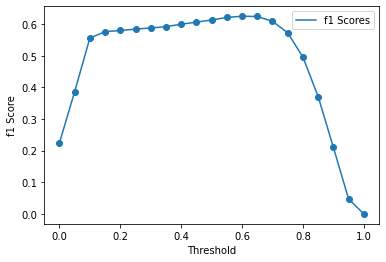

In [282]:
plt.plot(thresholds, scores)
plt.scatter(thresholds, scores)
plt.legend(['f1 Scores'])
plt.xlabel('Threshold')
plt.ylabel('f1 Score')

In [284]:
rnd = RandomForestClassifier()
param_grid = [
    {
        'max_depth': [None, 2, 3, 5],
        
        'min_samples_leaf': [2, 4, 6, 8], 
        'max_features': ['auto', 'sqrt', 'log2', None]}
]

grid_search = GridSearchCV(rnd, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_prepared, y_train)
print(grid_search.best_estimator_)
grid_search.score(X_test_prepared, y_test)

RandomForestClassifier(max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=128)


0.9357654576545251

In [286]:
f1_score(y_test, grid_search.predict(X_test_prepared))

0.6447507953340403

In [291]:
test_data = pd.read_csv('Test Data.csv')
test_data.drop(["id","current_job_years"], axis=1, inplace=True)
test_data.head()

,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_house_years
0,7393090,59,19,single,rented,no,Geologist,Malda,West Bengal,13
1,1215004,25,5,single,rented,no,Firefighter,Jalna,Maharashtra,10
2,8901342,50,12,single,rented,no,Lawyer,Thane,Maharashtra,14
3,1944421,49,9,married,rented,yes,Analyst,Latur,Maharashtra,12
4,13429,25,18,single,rented,yes,Comedian,Berhampore,West Bengal,11


In [292]:
test_data["profession"] = pd.factorize(test_data.profession, sort=True)[0]
test_data["city"] =pd.factorize(test_data.city, sort=True)[0]
test_data["state"]=pd.factorize(test_data.state, sort=True)[0]
test_data["married"]=pd.factorize(test_data.married, sort=True)[0]
test_data["house_ownership"]=pd.factorize(test_data.house_ownership, sort=True)[0]
test_data["car_ownership"]=pd.factorize(test_data.car_ownership, sort=True)[0]

In [293]:
test_data = preprocessor.transform(test_data)

In [294]:
y_pred= grid_search.predict(test_data)

In [295]:
ids = np.arange(1, y_pred.shape[0]+1)
Dict = {'id': ids, 'risk_flag': y_pred}
train_data = pd.DataFrame(Dict)
train_data.to_csv("Submission29.csv", index=False)